In [1]:
# Set up the environment with necessary imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

# Set plot style
sns.set_style("whitegrid")

# Computation Graphs and Automatic Differentiation

In this interactive lecture, we'll explore the fundamental concepts behind modern deep learning optimization:

1. **Computation Graphs**: How PyTorch represents operations
2. **Automatic Differentiation**: How PyTorch computes gradients
3. **Benefits of Autograd**: Handling complex functions
4. **Working with Autodiff**: Practical considerations

Each section contains explanations and hands-on exercises to build your understanding.

## 1. Computation Graphs

### 1.1 What is a Computation Graph?

A computation graph represents mathematical operations as a directed graph:
- **Nodes**: Variables (inputs, intermediate values, outputs)
- **Edges**: Operations between variables
- **Direction**: The flow of computation from inputs to outputs

Let's visualize a computation graph for a simple function:
$$f(x) = x^2 + 2x + 1$$

In [2]:
# Function to visualize a computation graph
def visualize_computation_graph(nodes, edges, edge_labels=None, node_labels=None):
    """
    Visualize a computation graph

    Parameters:
    - nodes: List of node names
    - edges: List of tuples (source, target) representing connections
    - edge_labels: Dictionary of edge labels {(source, target): operation}
    - node_labels: Dictionary of node labels {node: value}
    """
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')

    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, width=2, arrowsize=30, arrowstyle='-|>',min_target_margin=25)

    # Draw node labels
    # Define the bbox properties for transparency
    bbox_props = dict(boxstyle="round,pad=0.3",  # Or your preferred style
                      facecolor="white",  # Set facecolor to "none" for transparency
                      edgecolor='black',  # You can customize the border color
                      alpha=0.65)  # Adjust alpha (0 to 1) for desired transparency level
    if node_labels:
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10,bbox=bbox_props)
    else:
        nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edge labels
    if edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

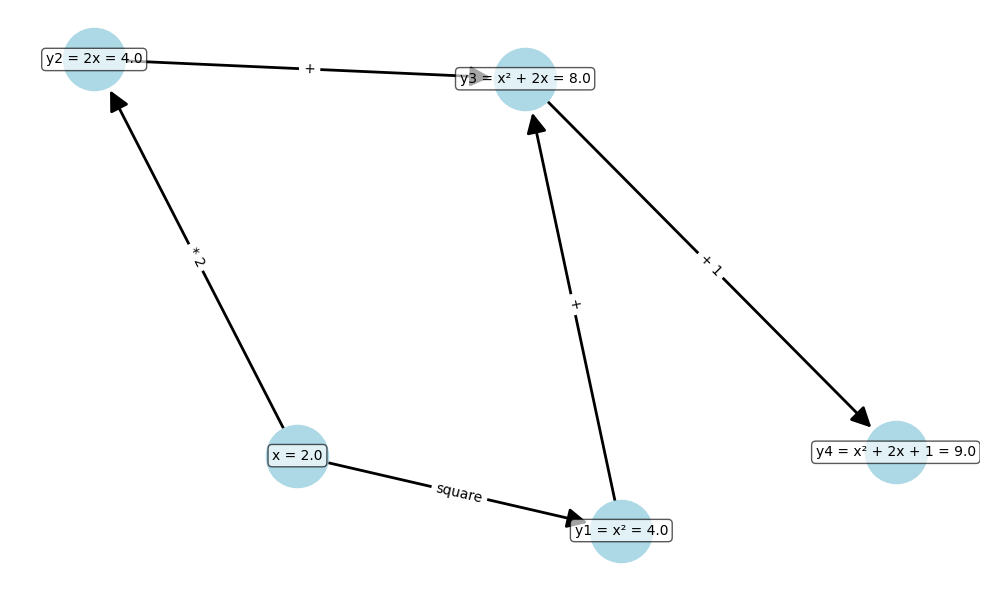

Function value at x = 2.0: 9.0


In [3]:
# Create the computation graph for f(x) = x^2 + 2x + 1
x_value = 2.0
x = torch.tensor(x_value, requires_grad=True)

# Build the graph step by step
y1 = x * x           # x^2
y2 = 2 * x           # 2x
y3 = y1 + y2         # x^2 + 2x
y4 = y3 + 1          # x^2 + 2x + 1

# Define nodes and edges for visualization
nodes = ['x', 'y1', 'y2', 'y3', 'y4']
edges = [('x', 'y1'), ('x', 'y2'), ('y1', 'y3'), ('y2', 'y3'), ('y3', 'y4')]

# Define edge labels (operations)
edge_labels = {
    ('x', 'y1'): 'square',
    ('x', 'y2'): '* 2',
    ('y1', 'y3'): '+',
    ('y2', 'y3'): '+',
    ('y3', 'y4'): '+ 1'
}

# Define node labels with values
node_labels = {
    'x': f'x = {x.item()}',
    'y1': f'y1 = x² = {y1.item()}',
    'y2': f'y2 = 2x = {y2.item()}',
    'y3': f'y3 = x² + 2x = {y3.item()}',
    'y4': f'y4 = x² + 2x + 1 = {y4.item()}'
}

# Visualize the graph
visualize_computation_graph(nodes, edges, edge_labels, node_labels)

print(f"Function value at x = {x_value}: {y4.item()}")

### 1.2 Exercise: Build Your Own Computation Graph

Now it's your turn to build a computation graph for the function:
$$g(x) = 3x^2 - 4x + 2$$

1. Create the variables and operations needed
2. Define the nodes, edges, and labels for visualization
3. Visualize the graph using the helper function

In [4]:
# Your solution here

### Solution 1.2

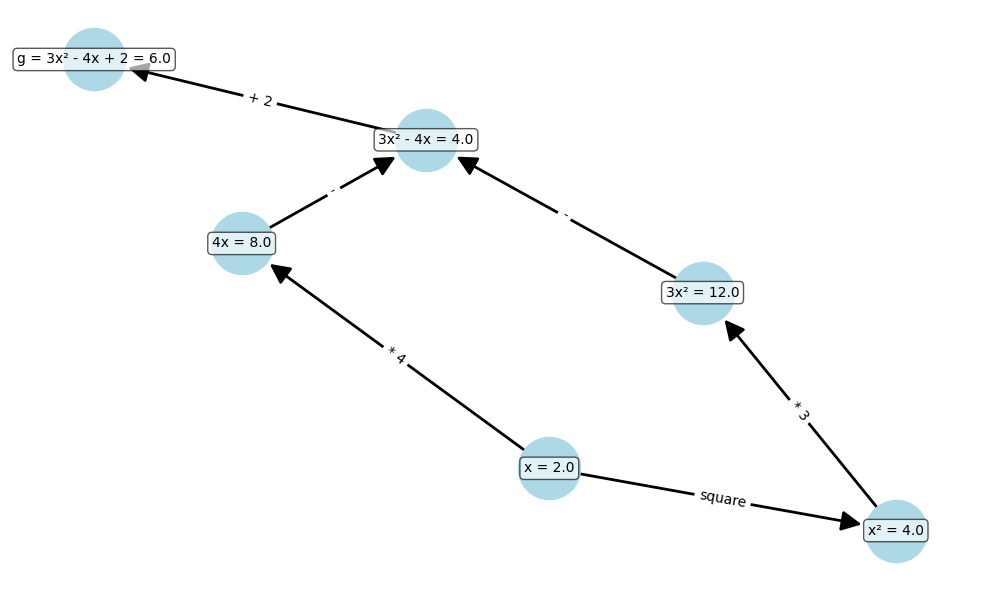

Function value at x = 2.0: 6.0


In [5]:
# Create the computation graph for g(x) = 3x^2 - 4x + 2
x_value = 2.0
x = torch.tensor(x_value, requires_grad=True)

# Build the graph step by step
x_squared = x * x        # x^2
term1 = 3 * x_squared    # 3x^2
term2 = 4 * x            # 4x
term3 = term1 - term2    # 3x^2 - 4x
g = term3 + 2            # 3x^2 - 4x + 2

# Define nodes and edges for visualization
nodes = ['x', 'x_squared', 'term1', 'term2', 'term3', 'g']
edges = [
    ('x', 'x_squared'),
    ('x_squared', 'term1'),
    ('x', 'term2'),
    ('term1', 'term3'),
    ('term2', 'term3'),
    ('term3', 'g')
]

# Define edge labels
edge_labels = {
    ('x', 'x_squared'): 'square',
    ('x_squared', 'term1'): '* 3',
    ('x', 'term2'): '* 4',
    ('term1', 'term3'): '-',
    ('term2', 'term3'): '-',
    ('term3', 'g'): '+ 2'
}

# Define node labels with values
node_labels = {
    'x': f'x = {x.item()}',
    'x_squared': f'x² = {x_squared.item()}',
    'term1': f'3x² = {term1.item()}',
    'term2': f'4x = {term2.item()}',
    'term3': f'3x² - 4x = {term3.item()}',
    'g': f'g = 3x² - 4x + 2 = {g.item()}'
}

# Visualize the graph
visualize_computation_graph(nodes, edges, edge_labels, node_labels)

print(f"Function value at x = {x_value}: {g.item()}")

## 2. Automatic Differentiation

### 2.1 Understanding Autograd

PyTorch's automatic differentiation (autograd) allows us to compute derivatives automatically. This works by:

1. **Building a dynamic computation graph** as operations are performed
2. **Recording operations** on variables that have `requires_grad=True`
3. **Applying the chain rule** to compute gradients during backward pass

The **chain rule** is a fundamental concept in calculus that allows us to compute derivatives of composite functions:

For a composite function $f(g(x))$, the derivative is:
$$\frac{d}{dx}f(g(x)) = \frac{df}{dg} \cdot \frac{dg}{dx}$$

For example, if $y = f(x) = x^2 + 2x + 1$, we can break it down:
- $y_1 = x^2$, so $\frac{dy_1}{dx} = 2x$
- $y_2 = 2x$, so $\frac{dy_2}{dx} = 2$
- $y_3 = y_1 + y_2$, so $\frac{dy_3}{dy_1} = 1$ and $\frac{dy_3}{dy_2} = 1$
- $y_4 = y_3 + 1$, so $\frac{dy_4}{dy_3} = 1$

Using the chain rule:
$$\frac{dy_4}{dx} = \frac{dy_4}{dy_3} \cdot \left(\frac{dy_3}{dy_1} \cdot \frac{dy_1}{dx} + \frac{dy_3}{dy_2} \cdot \frac{dy_2}{dx}\right) = 1 \cdot (1 \cdot 2x + 1 \cdot 2) = 2x + 2$$

PyTorch automates this process by traversing the computation graph backward from the output to the inputs.

#### Key methods in PyTorch's autograd:
- **`requires_grad=True`**: Tells PyTorch to track operations on this tensor
- **`.backward()`**: Computes gradients of the output with respect to inputs
- **`.grad`**: Stores the computed gradient
- **`.item()`**: Extracts a scalar value from a tensor

In [6]:
# Let's compute the gradient of our function f(x) = x^2 + 2x + 1
x = torch.tensor(2.0, requires_grad=True)
y = x**2 + 2*x + 1

# Compute the gradient
y.backward()

# Access the gradient
print(f"Function: f(x) = x^2 + 2x + 1")
print(f"Value at x = 2: {y.item()}")
print(f"Gradient at x = 2: {x.grad.item()}")
print(f"Expected gradient (2x + 2): {2*2 + 2}")

Function: f(x) = x^2 + 2x + 1
Value at x = 2: 9.0
Gradient at x = 2: 6.0
Expected gradient (2x + 2): 6


### 2.2 Gradients in Multiple Dimensions

For functions with multiple inputs, autograd computes partial derivatives with respect to each input.

Let's look at a 2D function: $f(x, y) = x^2 + y^2$

In [29]:
# Create a function to visualize 2D functions and their gradients
def visualize_function_and_gradient_2d(f, point=None, gradient_at_point=None, num_points=20, x_range=(-4, 4), y_range=(-4, 4)):
    """
    Visualize a 2D function and its gradient

    Parameters:
    - f: Function that takes x, y and returns z
    - x_range: Tuple (x_min, x_max)
    - y_range: Tuple (y_min, y_max)
    - point: Optional tuple (x0, y0, z0) to mark a specific point
    - num_points: Number of points in each dimension for the grid
    """
    # Create a grid of points
    x_vals = np.linspace(x_range[0], x_range[1], num_points)
    y_vals = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Compute function values
    Z = np.zeros_like(X)
    grad_x = np.zeros_like(X)
    grad_y = np.zeros_like(X)

    # Compute function values and gradients using autograd
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x_tensor = torch.tensor(X[i, j], requires_grad=True)
            y_tensor = torch.tensor(Y[i, j], requires_grad=True)

            # Compute function value
            z = f(x_tensor, y_tensor)
            Z[i, j] = z.item()

            # Compute gradients
            z.backward()
            grad_x[i, j] = x_tensor.grad.item()
            grad_y[i, j] = y_tensor.grad.item()

            # Reset gradients for next iteration
            x_tensor.grad.zero_()
            y_tensor.grad.zero_()

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 5))

    # 3D surface plot
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.8)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax1.set_zlabel('$f(x,y)$')
    ax1.set_title('3D Surface Plot')

    # Mark the specific point if provided
    if point is not None:
        x0, y0, z0 = point
        ax1.scatter([x0], [y0], [z0], color='red', s=50)

    # Contour plot with gradient field
    ax2 = fig.add_subplot(1, 3, 2)
    contour = ax2.contourf(X, Y, Z, 20, cmap=cm.coolwarm)
    ax2.quiver(X, Y, grad_x, grad_y, color='black', scale=50)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax2.set_title('Contour Plot with Gradient Field')
    plt.colorbar(contour, ax=ax2)

    # Mark the specific point if provided
    if point is not None and gradient_at_point is not None:
        x0, y0, _ = point
        ax2.plot(x0, y0, 'ro', markersize=10)
        grad_x0 = gradient_at_point[0]
        grad_y0 = gradient_at_point[1]
        ax2.quiver(x0, y0, grad_x0, grad_y0, color='red', scale=10)
        ax2.text(x0+0.1, y0+0.1, f'∇f({x0},{y0}) = [{grad_x0:.2f}, {grad_y0:.2f}]', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Gradient magnitude plot
    ax3 = fig.add_subplot(1, 3, 3)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    contour2 = ax3.contourf(X, Y, grad_magnitude, 20, cmap='viridis')
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$y$')
    ax3.set_title('Gradient Magnitude')
    plt.colorbar(contour2, ax=ax3)

    plt.tight_layout()
    plt.show()

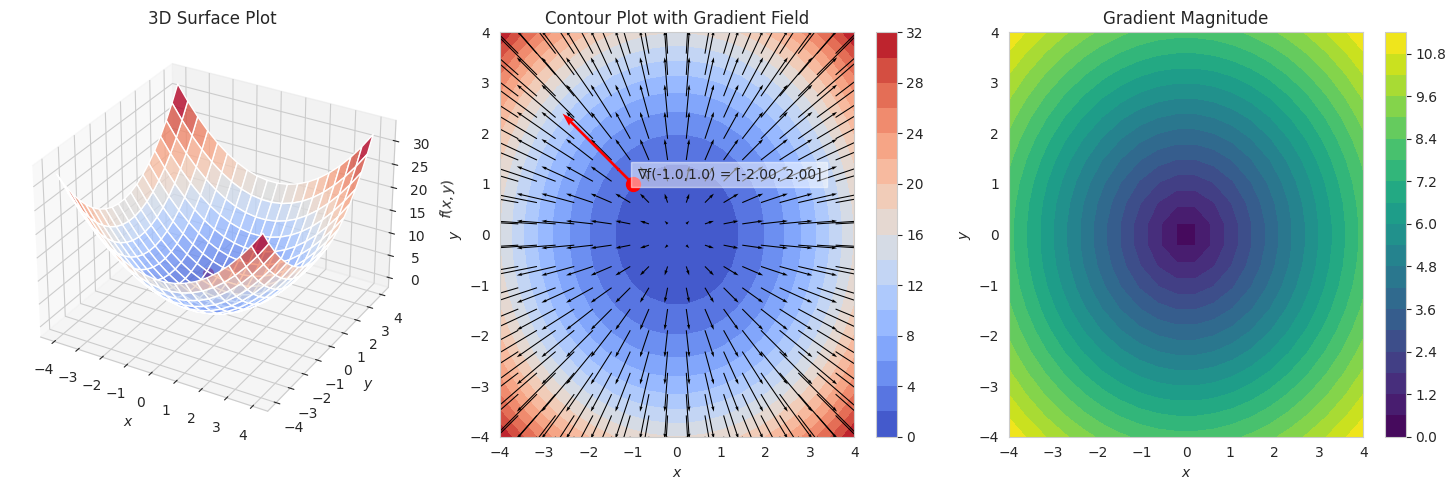

In [30]:
# Define a simple 2D function
f_2d = lambda x, y: x**2 + y**2

# Point to highlight
x0 = torch.tensor(-1.0, requires_grad=True)
y0 = torch.tensor(1.0, requires_grad=True)
z0 = f_2d(x0, y0)

# take gradient
z0.backward()

# compute gradient at point
gradient_at_point = torch.tensor([x0.grad.item(), y0.grad.item()])

# make sure to only provide items to the function
point = torch.tensor([x0.item(), y0.item(), z0.item()])

# Visualize
visualize_function_and_gradient_2d(f_2d, point=point, gradient_at_point=gradient_at_point)

### 2.3 Exercise: Compute and Visualize Gradients

Now it's your turn! For the function $h(x, y) = x^2 - y^2$:

1. Define the function
2. Compute the gradient at the point (0, 2) using PyTorch's autograd
3. Visualize the function and its gradient using our helper function

In [35]:
# Your solution here

### Solution 2.3

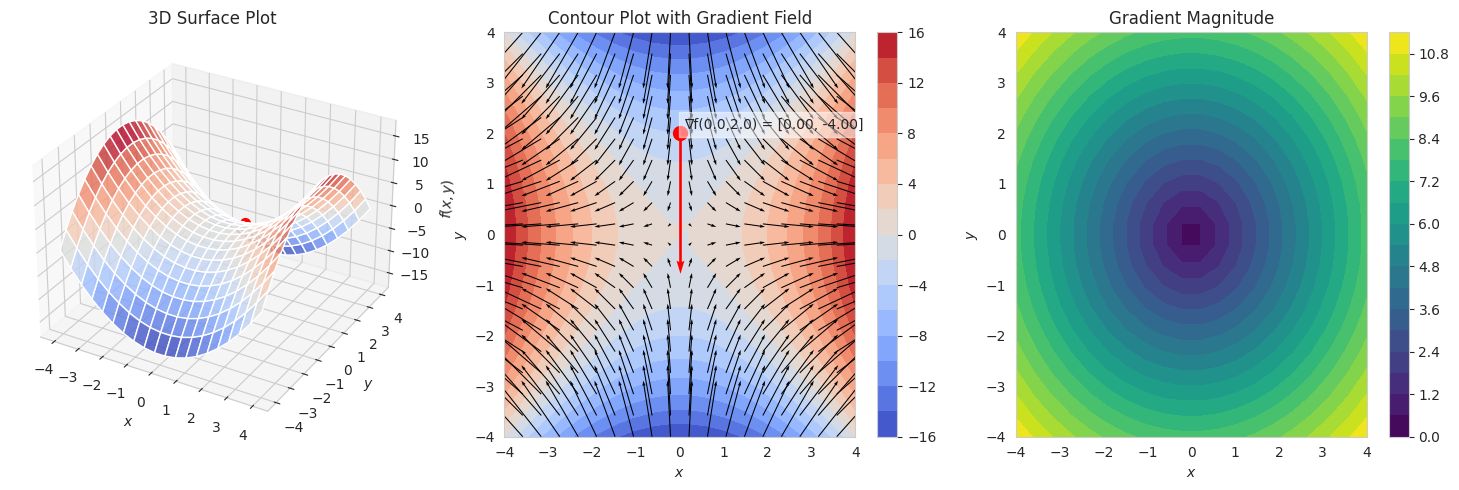

In [36]:
# 1. Define the function
h = lambda x, y: x**2 - y**2

# 2. Compute the gradient at (1, 2) using PyTorch's autograd
x = torch.tensor(0.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z = h(x, y)
z.backward()
gradient_at_point = torch.tensor([x.grad.item(), y.grad.item()])

# 3. Visualize the function and its gradient
visualize_function_and_gradient_2d(h, point=torch.tensor([x.item(), y.item(), z.item()]), gradient_at_point=(x.grad, y.grad))

## 3. The Benefit of Autograd: Computing Gradients for arbitrary functions

Autograd's real power is its ability to handle functions where calculating derivatives by hand would be difficult.

### 3.1 Example:

Let's look at the following function: $f(x, y) = cos((3 + cos(x+2*y)^3)^{0.5} * sin(y-x))$

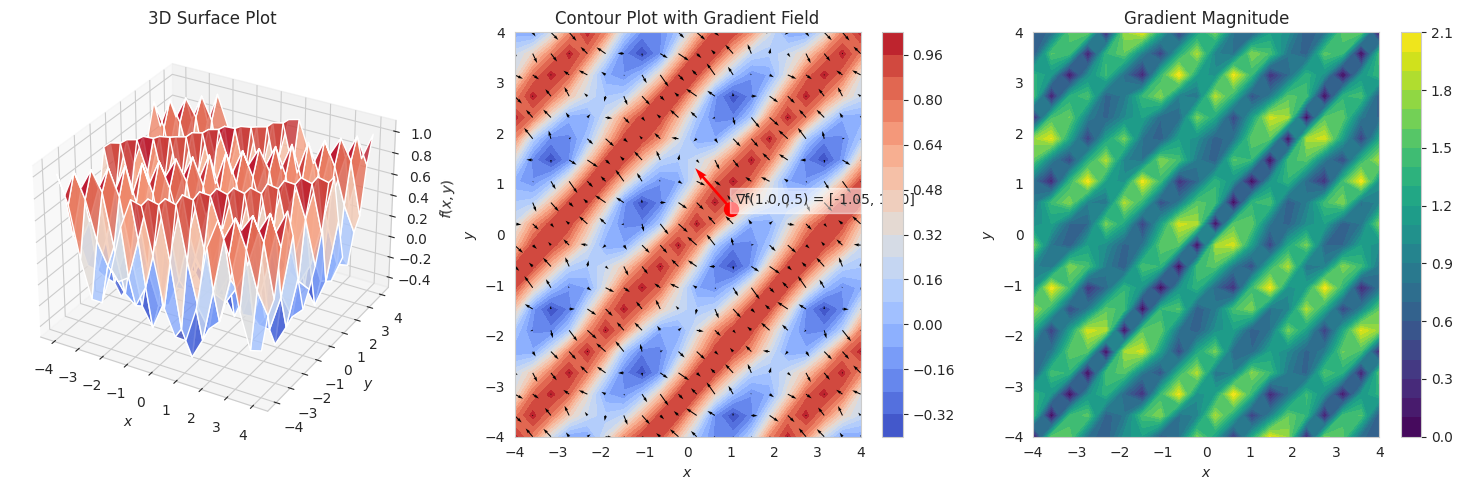

In [45]:
# Define the function
def f(x, y):
    return torch.cos((3 + torch.cos(x + 2*y)**3)**(0.5) * torch.sin(y - x))

# Compute gradients at (1, 0.5)
x0 = torch.tensor(1.0, requires_grad=True)
y0 = torch.tensor(0.5, requires_grad=True)
z0 = f(x0, y0)
z0.backward()
gradient_at_point = torch.tensor([x0.grad.item(), y0.grad.item()])
point = torch.tensor([x0.item(), y0.item(), z0.item()])

# Visualize
visualize_function_and_gradient_2d(f, point=point, gradient_at_point=gradient_at_point)

### 3.2 Exercise: Your Scary-Looking Function

Now it's your turn to experiment with autograd on a function of your choosing!

1. Create your own scary-looking function (you can check its 3D shape at https://www.desmos.com/3d)
2. Compute its gradient at a point of your choice using PyTorch's autograd
3. Visualize your function and its gradient

Be creative! Try combinations of trigonometric functions, exponentials, polynomials, etc.

In [12]:
# Your solution here

### Solution 3.2 (Example)

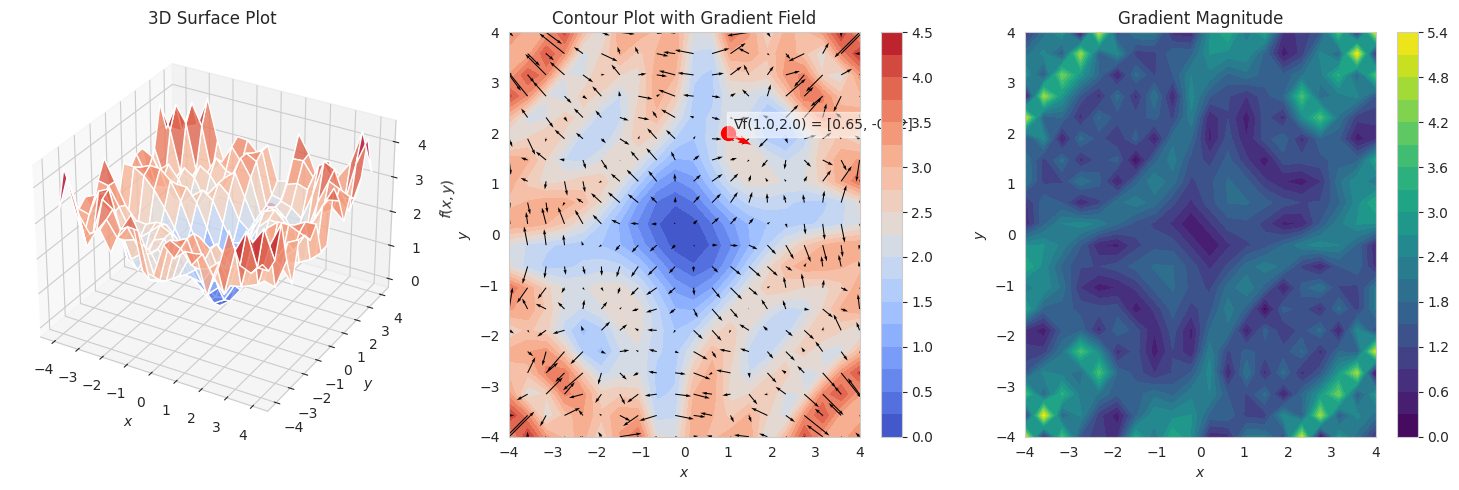

In [48]:
# 1. Create a scary function
# Let's try: f(x, y) = sin(x*y) * cos(x-y) + log(1 + x^2 + y^2)

# Define the function
def my_scary_f(x, y):
    return torch.sin(x*y) * torch.cos(x-y) + torch.log(1 + x**2 + y**2)

# Choose a point
x0, y0 = torch.tensor(1.0, requires_grad=True), torch.tensor(2.0, requires_grad=True)
z0 = my_scary_f(x0, y0)
z0.backward()
gradient_at_point = torch.tensor([x0.grad.item(), y0.grad.item()])
point = torch.tensor([x0.item(), y0.item(), z0.item()])

# Compute gradients and visualize
visualize_function_and_gradient_2d(my_scary_f, point=point, gradient_at_point=gradient_at_point)

## 4. Working with Autodiff

### 4.1 Computing Gradients for Different Inputs

We often want to use the same function with different inputs. Let's see how to compute gradients
for the same function at different input points:

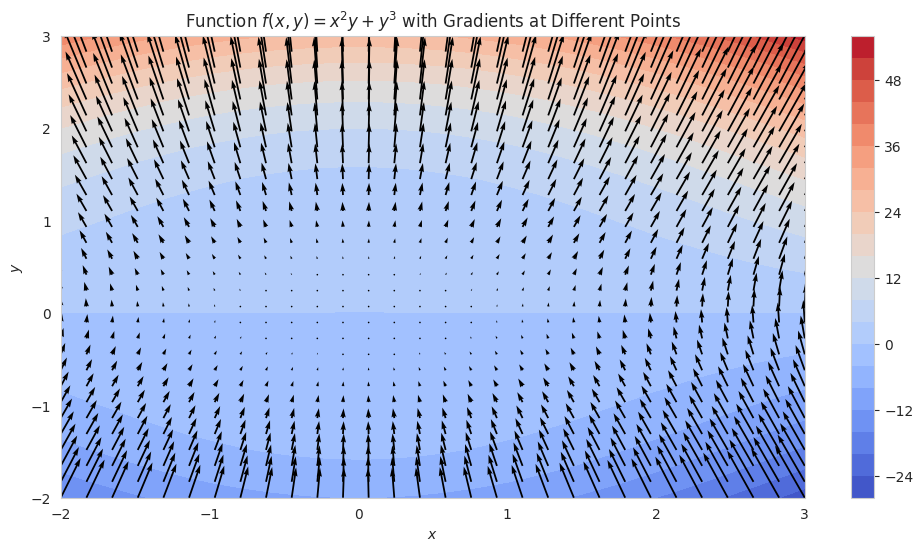

In [52]:
# Function: f(x, y) = x^2 * y + y^3

def f_demo(x, y):
    return x**2 * y + y**3

# Visualize many gradients on the same graph
fig = plt.figure(figsize=(12, 6))

# Create the contour plot
x_vals = np.linspace(-2, 3, 30)
y_vals = np.linspace(-2, 3, 30)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute function values
Z = np.zeros_like(X)
grad_x = np.zeros_like(X)
grad_y = np.zeros_like(X)

# Compute function values and gradients using autograd
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x_tensor = torch.tensor(X[i, j], requires_grad=True)
        y_tensor = torch.tensor(Y[i, j], requires_grad=True)

        # Compute function value
        z = f_demo(x_tensor, y_tensor)
        Z[i, j] = z.item()

        # Compute gradients
        z.backward()
        grad_x[i, j] = x_tensor.grad.item()
        grad_y[i, j] = y_tensor.grad.item()

        ## THIS IS WHERE THE RELEVANT CODE IS ##
        # Reset gradients for next iteration
        x_tensor.grad.zero_()
        y_tensor.grad.zero_()

# Plot
contour = plt.contourf(X, Y, Z, 20, cmap=cm.coolwarm)
plt.quiver(X, Y, grad_x, grad_y, color='black', scale=300)

plt.colorbar(contour)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Function $f(x,y) = x^2y + y^3$ with Gradients at Different Points')
plt.grid(True)
plt.show()

### 4.2 Using requires_grad=False

Sometimes, we don't need to compute gradients for all inputs. We can control this with `requires_grad=False`:

In [50]:
# Create tensors with different requires_grad settings
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=False)  # No gradients for y

# Compute function
f = x**2 * y

# run autodiff
f.backward()

print(f"Function f = x^2 * y at (2, 3): {f.item()}")
print(f"∂f/∂x: {x.grad.item()}")
print(f"∂f/∂y: {'Not computed (requires_grad=False)'}")

# We can also temporarily disable gradient tracking with torch.no_grad()
with torch.no_grad():
    # No operations here will track gradients
    z = x * y
    print(f"\nComputed z = x * y = {z.item()} without tracking gradients")
    print(f"z.requires_grad: {z.requires_grad}")

Function f = x^2 * y at (2, 3): 12.0
∂f/∂x: 12.0
∂f/∂y: Not computed (requires_grad=False)

Computed z = x * y = 6.0 without tracking gradients
z.requires_grad: False


### 4.3 Exercise: Computing and Comparing Gradients

In this exercise, you'll explore how gradients change for different input values:

1. Pick a function of your choice (e.g., $f(x, y) = \sin(x + y) * e^{xy}$)
2. Visualize its gradient field and gradient at a particular point using the helper function you used above.
3. Compute its gradient at two other points.

In [16]:
# Your solution here

### Solution 4.3

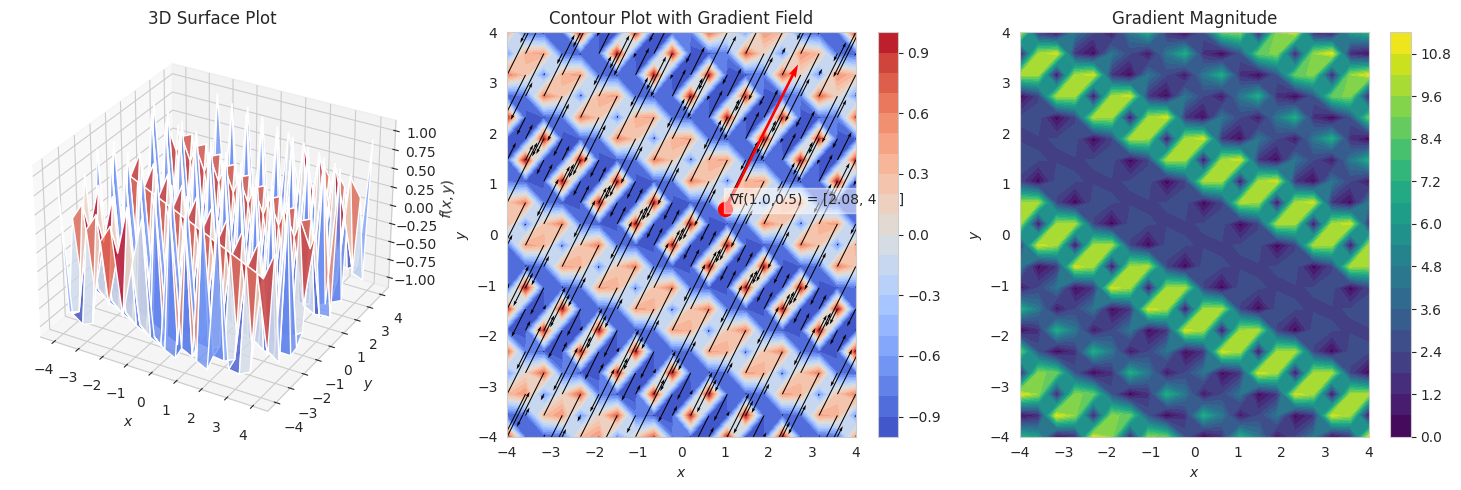

Point 1: (0.0, 0.0)
  Function value: -0.9577
  ∂f/∂x: -0.0000
  ∂f/∂y: -0.0000

Point 2: (1.0, 1.0)
  Function value: -0.5585
  ∂f/∂x: -1.3972
  ∂f/∂y: -2.7943



In [54]:
# 1. Choose a function
def f(x, y):
    return torch.cos((3 + torch.cos(x + 2*y)**3)**(2))

# Compute gradients at (1, 0.5)
x0 = torch.tensor(1.0, requires_grad=True)
y0 = torch.tensor(0.5, requires_grad=True)
z0 = f(x0, y0)
z0.backward()
gradient_at_point = torch.tensor([x0.grad.item(), y0.grad.item()])
point = torch.tensor([x0.item(), y0.item(), z0.item()])

# 2. Visualize
visualize_function_and_gradient_2d(f, point=point, gradient_at_point=gradient_at_point)



# 3. Compute gradients at two other points
def compute_gradient_at_point(f, x_val, y_val):
    x = torch.tensor(x_val, requires_grad=True)
    y = torch.tensor(y_val, requires_grad=True)

    z = f(x, y)
    z.backward()

    return {
        'point': (x_val, y_val),
        'f_value': z.item(),
        'grad_x': x.grad.item(),
        'grad_y': y.grad.item()
    }

# Compute at two points
point1 = compute_gradient_at_point(f, 0.0, 0.0)
point2 = compute_gradient_at_point(f, 1.0, 1.0)

# Print results
for i, point in enumerate([point1, point2], 1):
    print(f"Point {i}: ({point['point'][0]}, {point['point'][1]})")
    print(f"  Function value: {point['f_value']:.4f}")
    print(f"  ∂f/∂x: {point['grad_x']:.4f}")
    print(f"  ∂f/∂y: {point['grad_y']:.4f}")
    print()

## Conclusion

In this lecture, we've explored:

1. **Computation Graphs**: How PyTorch represents mathematical operations as a network

2. **Automatic Differentiation**: How PyTorch computes gradients by traversing the computation graph and applying the chain rule

3. **Benefits of Autograd for Complex Functions**: How autograd helps with complicated derivatives

4. **Working with Autodiff**: Practical considerations for gradient computation

These concepts form the foundation of deep learning optimization. When we train neural networks, we're essentially:

1. Building a computation graph (the forward pass)
2. Computing gradients (the backward pass)
3. Updating parameters based on these gradients (optimization)

Understanding these concepts will help you debug and improve your neural network implementations!